## Notebook for FSLR using PHCA

In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt

# self-made modules
from modules.module_GenerateDataset import fslDataset as fsl
from modules.module_SumFrameDiff import sumFrameDiff as sfd
from modules.module_ClassificationFunctions import shuffle_per_class, kfoldDivideData, fivefoldDivideData, get_classificationReport
from modules.module_PHCA import PersistentHomologyClassifier

import warnings
warnings.filterwarnings("ignore") 

In [2]:
# initial parameters
data_name = 'Filipino Sign Language'
folds = 5
classes = 3
data_per_class = 20
zip_path = 'clips.zip'

classificationMeasurements = ['precision', 'f1-score', 'specificity', 'recall', 'support', 'accuracy']

#### Dataset Collection

In [4]:
print('\n Collecting data from dataset ...')
dataset_paths = fsl.generate_dataset(fsl, zip_path, numclass=classes)
num_data = len(dataset_paths['data'])

FSL_dataset = {'data': [], 'target': dataset_paths['target']}
for n in range(num_data):
    vidpath = dataset_paths['data'][n]
    sumframe = sfd.SumFrameDiff(sfd, vidpath)
    # FSL_dataset['data'][n] = sumframe
    FSL_dataset['data'].append(sumframe)

# save FSL_Dataset into an npy file
np.save(f"FSLdataset_{str(classes)}classes.npy", FSL_dataset)
print('Data collected and saved in an npy file.')


Data collected and saved in an npy file.


In [4]:
# loading dataset from npy file
FSL_dataset = np.load(f"FSLdataset_{str(classes)}classes.npy", allow_pickle=True)
FSL_dataset = {'data': FSL_dataset.item().get('data'),
               'target': FSL_dataset.item().get('target')}

In [13]:
len(FSL_dataset['data'][0])

230400

In [5]:
# sorting dataset in increasing target values
sorted_inds = np.array(FSL_dataset['target']).argsort()
FSL_dataset['data'], FSL_dataset['target'] = [FSL_dataset['data'][i] for i in sorted_inds], [FSL_dataset['target'][i] for i in sorted_inds]

In [6]:
# shuffling dataset per class
FSLData, FSLTarget = shuffle_per_class(FSL_dataset, data_per_class, classes)
print('\n Data collection finished. Features extracted.')


 Data collection finished. Features extracted.


#### Five Fold Validation

In [7]:
fivefoldData, fivefoldTarget = kfoldDivideData(FSLData, FSLTarget, data_per_class)
# fivefoldData, fivefoldTarget = fivefoldDivideData(FSLData, FSLTarget)
len(fivefoldTarget)

5

In [8]:
method_labels = {'true_labels': [], 'phca': []}

print("Starting fivefold validation")
for val in range(folds):
    print(f"\nRunning validation {val}")

    x_train, y_train, x_test, y_test = [], [], [], []
    for j in range(folds):
        if j == val:
            x_test += fivefoldData[j]
            y_test += fivefoldTarget[j]
        else:
            x_train += fivefoldData[j]
            y_train += fivefoldTarget[j]
    
    print("\nThe PHCA model is learning from the data...")

    # Persistent Homology Classifier
    PHCmodel = PersistentHomologyClassifier()
    PHCmodel.fit(x_train, y_train)

    print("Model finished learning.")
    print("The model is now predicting new data.")

    method_labels['true_labels'] += y_test
    for y in range(len(y_test)):
        method_labels["phca"].append(PHCmodel.predict(x_test[y]))
    
    print("Model is finished predicting.")


Starting fivefold validation

Running validation 0

The PHCA model is learning from the data...
Model finished learning.
The model is now predicting new data.
Model is finished predicting.

Running validation 1

The PHCA model is learning from the data...
Model finished learning.
The model is now predicting new data.
Model is finished predicting.

Running validation 2

The PHCA model is learning from the data...
Model finished learning.
The model is now predicting new data.
Model is finished predicting.

Running validation 3

The PHCA model is learning from the data...
Model finished learning.
The model is now predicting new data.
Model is finished predicting.

Running validation 4

The PHCA model is learning from the data...
Model finished learning.
The model is now predicting new data.
Model is finished predicting.


#### Classification Report

In [9]:
from sklearn.metrics import classification_report

print(classification_report(method_labels['true_labels'], method_labels['phca']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.70      0.70      0.70        20
           2       0.75      0.75      0.75        20

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



In [10]:
classificationReport = get_classificationReport(method_labels)

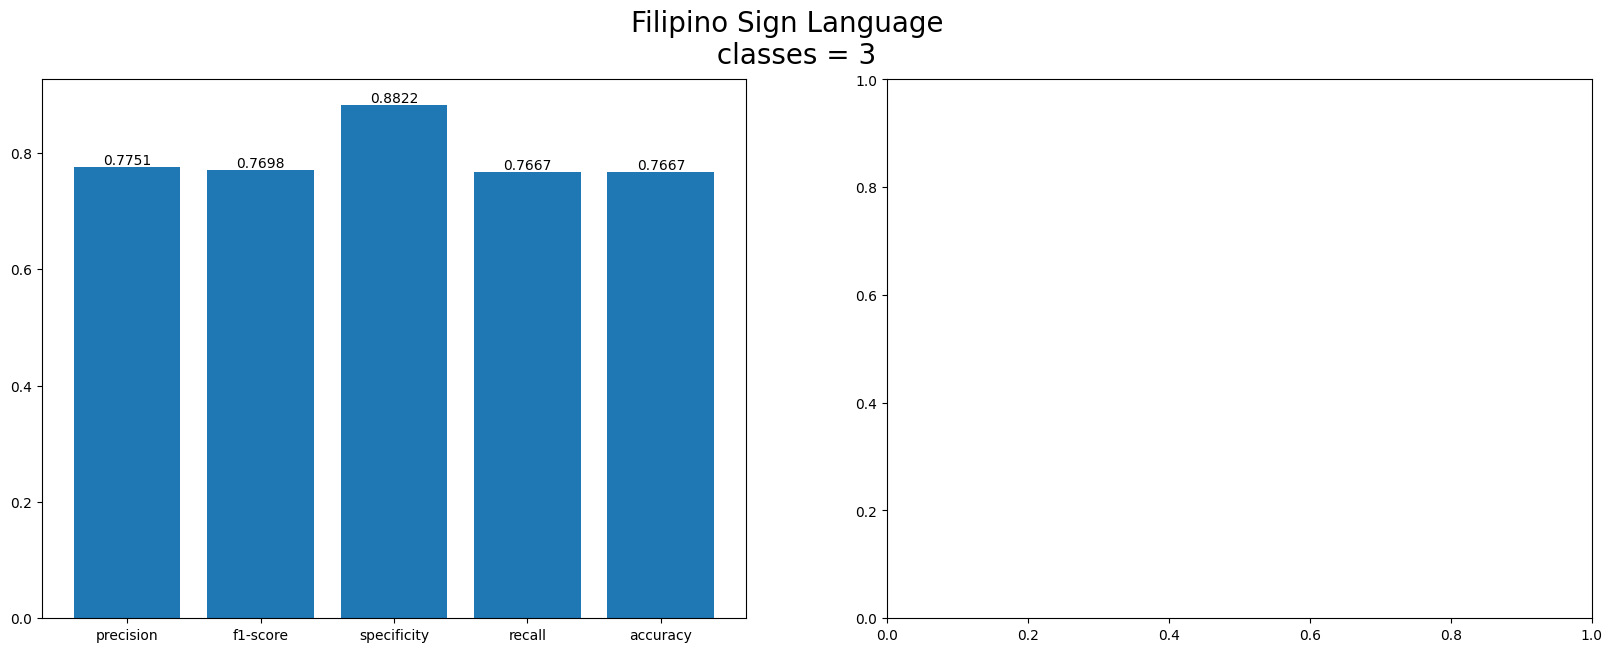

In [13]:
fig, axs = plt.subplots(1,2, figsize=(20, 7))
axs = axs.flatten()

fig.suptitle(f'{data_name} \n classes = {classes}', fontsize=20)

values = []
measures = []
for measurement in classificationMeasurements:
    if measurement == 'accuracy':
        values.append(classificationReport['phca'][measurement])
        measures.append(measurement)
    elif measurement == 'support':
        sup_value = classificationReport['phca']['macro avg'][measurement]
    else:
        values.append(classificationReport['phca']['macro avg'][measurement])
        measures.append(measurement)

for idx in range(len(axs)):
    if idx == 1:
        # axs[idx].bar('support', sup_value)
        pass
    else:
        p = axs[idx].bar(measures, values)
        axs[idx].bar_label(p, [round(v,4) for v in values])


In [14]:
method_labels['true_labels'][15:30], method_labels['phca'][15:30]

([0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0],
 [0, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 0])